In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)

os.chdir('gdrive/My Drive/Data_science_eng/finalproject/')
print("Current working directory: {0}".format(os.getcwd()))

Mounted at /content/gdrive
Current working directory: /content/gdrive/My Drive/Data_science_eng/finalproject


In [2]:
import string
import os
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import vgg16 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

In [3]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

tf.test.is_built_with_cuda()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



True

In [4]:
text_folder="./data/Flickr_Data/Flickr_Data/Flickr_TextData/"
img_folder="./data/Flickr_Data/Flickr_Data/Images/"
glove_folder="./data/"
proc_folder="./data/"
def load_text(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.split('\n')
    file.close()
    return text
train_imgs = load_text(os.path.join(text_folder, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(text_folder, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(text_folder, "Flickr_8k.devImages.txt"))
train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

print(test_imgs)

['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg', '1258913059_07c613f7ff.jpg', '241347760_d44c8d3a01.jpg', '2654514044_a70a6e2c21.jpg', '2339106348_2df90aa6a9.jpg', '256085101_2c2617c5d0.jpg', '280706862_14c30d734a.jpg', '3072172967_630e9c69d0.jpg', '3482062809_3b694322c4.jpg', '1167669558_87a8a467d6.jpg', '2847615962_c330bded6e.jpg', '3344233740_c010378da7.jpg', '2435685480_a79d42e564.jpg', '3110649716_c17e14670e.jpg', '2511019188_ca71775f2d.jpg', '2521770311_3086ca90de.jpg', '2723477522_d89f5ac62b.jpg', '2218609886_892dcd6915.jpg', '3745451546_fc8ec70cbd.jpg', '2844018783_524b08e5aa.jpg', '3100251515_c68027cc22.jpg', '2207244634_1db1a1890b.jpg', '2943023421_e297f05e11.jpg', '3286822339_5535af6b93.jpg', '2479652566_8f9fac8af5.jpg', '1394368714_3bc7c19969.jpg', '872622575_ba1d3632cc.jpg', '2309860995_c2e2a0feeb.jpg', '241347204_007d83e252.jpg', '3502343542_f9b46688e5.jpg', '757332692_6866ae545c.jpg', '2748729903_3c7c920c4d.jpg', '494792770_2c5f767ac

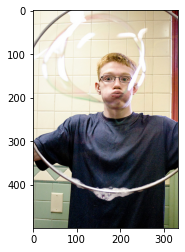

In [5]:
image999 = train_imgs[675]
image_999 = load_img(os.path.join(img_folder, image999))
plt.imshow(image_999)

In [6]:
def get_inceptionv3_feature(img_folder, img_name, model):
    # inception v3 model
    img = load_img(os.path.join(img_folder, img_name), target_size=(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = model.predict(x)
    x = np.reshape(x, x.shape[1])
    return x
# Get the InceptionV3 model trained on imagenet data
model_inceptionv3 = InceptionV3(weights='imagenet')
model_inceptionv3 = Model(model_inceptionv3.input, model_inceptionv3.layers[-2].output)

incv3_features_img999 = get_inceptionv3_feature(img_folder, train_imgs[999], model_inceptionv3)

encoded_images_file = open("./data/encoded_training_images.pkl","rb")
encoded_training_images = pk.load(encoded_images_file)

# for img in train_imgs:

#   encoded_training_images[img] = get_inceptionv3_feature(img_folder, img, model_inceptionv3)

# with open(os.path.join(proc_folder, 'train_encoded_images.p'), 'wb') as f:

#   pk.dump(encoded_training_images,f)

print("Shape of image vector for one image: {}".format(incv3_features_img999.shape))

96124928/96112376 [==============================] - 1s 0us/step
Shape of image vector for one image: (2048,)


In [7]:
# with open(os.path.join(proc_folder, 'encoded_training_images.pkl'), 'wb') as f:

#   pk.dump(encoded_training_images,f)

In [22]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc:
        tokens = line.split()
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('#')[0]
        image_desc = 'startseq '+' '.join(image_desc) + ' endseq'
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping
    
def clean_description(desc_dict):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc_list[i] =  ' '.join(desc)
            
descriptions = load_text(os.path.join(text_folder, "Flickr8k.token.txt"))
dictdesc = load_text(os.path.join(text_folder, "Flickr8k.token.txt"))
desc_dict = load_descriptions(descriptions)
clean_description(desc_dict)

In [23]:
dictdesc

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [9]:
# Create the vocabulary.
vocabulary = set()
for key in desc_dict.keys():
    [vocabulary.update(d.split()) for d in desc_dict[key]]
    
vocabulary = list(vocabulary)
print('Original Vocabulary Size: %d' % len(vocabulary))
# NOTE: index starts from 1, not 0.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
embeddings_index = {} 
f = open(os.path.join(glove_folder, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print("Volcabulary size of GLOVE: {}".format(len(embeddings_index)))

# Get 200-dim dense vector for each of words in vocabulary
embedding_dim = 200
vocab_size = len(vocabulary)+1   
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
print("Shape of embedding weights for the current vocabulary {}".format(embedding_matrix.shape))

Original Vocabulary Size: 8810
Volcabulary size of GLOVE: 400000
Shape of embedding weights for the current vocabulary (8811, 200)


In [10]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [11]:
max_length = max_length(desc_dict)
# print('Max Description Length: %d' % max_length)
# num_photos_per_batch =5
# batch_generator = data_generator(descriptions=desc_dict, photos=encoded_training_images, wordtoix=wordtoix, max_length=max_length, 
#                num_photos_per_batch=num_photos_per_batch)

# inputs, outputs = next(batch_generator)
# print(inputs[0].shape)
# print(inputs[1].shape)
# print(outputs.shape)

In [12]:
#feature extractor
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [13]:
print(encoded_training_images)

{'2513260012_03d33305cf.jpg': array([0.08447914, 0.09467596, 0.09229985, ..., 0.07690589, 1.4561857 ,
       0.451191  ], dtype=float32), '2903617548_d3e38d7f88.jpg': array([0.17603171, 0.51566577, 0.4132955 , ..., 0.65110505, 0.35608917,
       0.9773245 ], dtype=float32), '3338291921_fe7ae0c8f8.jpg': array([0.16187187, 0.13512506, 0.04707858, ..., 0.35250157, 0.25436473,
       0.38996512], dtype=float32), '488416045_1c6d903fe0.jpg': array([0.45007274, 0.07103871, 0.14107414, ..., 0.5103904 , 1.1378504 ,
       0.47370875], dtype=float32), '2644326817_8f45080b87.jpg': array([0.2610393 , 0.85202014, 0.03016784, ..., 0.05509176, 1.015024  ,
       0.93701726], dtype=float32), '218342358_1755a9cce1.jpg': array([0.7362428 , 0.16550519, 0.12633775, ..., 0.32769352, 0.28599408,
       0.585533  ], dtype=float32), '2501968935_02f2cd8079.jpg': array([0.15158756, 0.06291357, 1.0291827 , ..., 0.07257836, 1.0984013 ,
       0.9973055 ], dtype=float32), '2699342860_5288e203ea.jpg': array([0.3013

In [14]:
temp = desc_dict.items()
print(list(temp)[:10])

[('1000268201_693b08cb0e.jpg', ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']), ('1001773457_577c3a7d70.jpg', ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']), ('1002674143_1b742ab4b8.jpg', ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq',

In [15]:
desc_dict_train = {key: desc_dict[key] for key in encoded_training_images.keys()}
# max_length = max_length(desc_dict_train)
print('Max Description Length: %d' % max_length)
num_photos_per_batch =32
train_generator = data_generator(descriptions=desc_dict_train, photos=encoded_training_images, wordtoix=wordtoix, max_length=max_length, 
               num_photos_per_batch=num_photos_per_batch)

# inputs, outputs = next(batch_generator)
# print(inputs[0].shape)
# print(inputs[1].shape)
# print(outputs.shape)

Max Description Length: 34


In [16]:
# num_epoch = 5

# for ep in range(1, num_epoch):
#     print("run epoch {}".format(ep))
#     model.fit_generator(generator=train_generator, steps_per_epoch=len(encoded_training_images), epochs=1)
#     model.save(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_{}epochs.h5".format(ep)))

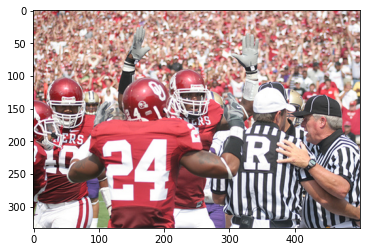

In [31]:
testimage = test_imgs[30]
testimage = load_img(os.path.join(img_folder, testimage))
plt.imshow(testimage)
testimage_features = get_inceptionv3_feature(img_folder, test_imgs[30], model_inceptionv3)

In [32]:
def caption_generator_incpt3glove(photo, model, max_length, wordtoix, ixtoword):
    # start with 'stratseq'
    in_text = ['startseq']
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = pad_sequences([seq], maxlen=max_length)[0]

        in_put = [np.array([photo]), np.array([seq])]
        out_word = model.predict(in_put, verbose=0)
        out_word = np.argmax(out_word)
        out_word = ixtoword[out_word]
        if out_word is None:
          break
        in_text.append(out_word)
        if out_word == 'endseq':
          break
    return in_text

In [19]:
# def getimages()

SyntaxError: ignored

In [33]:
from tensorflow import keras
version=4
testmodel=keras.models.load_model(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_{}epochs.h5".format(version)))
caption_generator_incpt3glove(photo=testimage_features, model=model, max_length=max_length, wordtoix=wordtoix, ixtoword=ixtoword)

['startseq',
 'youn',
 'youn',
 'youn',
 'youn',
 'youn',
 'porch',
 'porch',
 'youn',
 'youn',
 'youn',
 'youn',
 'porch',
 'youn',
 'youn',
 'youn',
 'porch',
 'youn',
 'youn',
 'youn',
 'porch',
 'porch',
 'youn',
 'youn',
 'youn',
 'youn',
 'youn',
 'youn',
 'porch',
 'porch',
 'youn',
 'youn',
 'youn',
 'youn',
 'youn']